## Setup Models

In [ ]:
!pip install langchain_openai
!pip install langgraph
!pip install langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.4/70.4 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.7 MB/s eta 0:00:00


In [ ]:
from langchain_openai import AzureChatOpenAI
from langchain_openai import AzureOpenAIEmbeddings
import os

#Setup the environment variables
os.environ["AZURE_OPENAI_API_KEY"]="<YOUR KEY>"
os.environ["AZURE_OPENAI_ENDPOINT"]="<YOUR END POINT>"

#Setup the LLM
model = AzureChatOpenAI(
    azure_deployment="gpt-4o" ,
    api_version="2024-12-01-preview",
    model="gpt-4o"
)


## 05.02. Engineer prompts for reflection

In [ ]:
summarizer_prompt="""
You are an document summarizer who can summarize a document provide to you.
For the input provided, create a summary with less than 50 words.
If the user has provides critique, responsed with a revised version of your previous attempts
"""

reviewer_prompt="""
You are a reviewer grading summaries for an article.
Compare the user input document and generated summary.
Check if the summary accurately reflects the contents of the document.
Provide recommendations for improvement in less than 50 words.
"""


## 05.03. Setup the summary-with-review Agent

In [ ]:
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage

class SummaryAgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

class SummaryAgent:

    def __init__(self, model, summarizer_prompt, reviewer_prompt, debug=False):

        self.model=model
        self.summarizer_prompt=summarizer_prompt
        self.reviewer_prompt=reviewer_prompt
        self.debug=debug
        #No tools in this case

        summary_agent_graph=StateGraph(SummaryAgentState)
        summary_agent_graph.add_node("summarizer",self.generate_summary)
        summary_agent_graph.add_node("reviewer",self.review_summary)

        summary_agent_graph.add_conditional_edges(
            "summarizer",
            self.should_continue,
            {True: "reviewer", False: END }
        )
        summary_agent_graph.add_edge("reviewer", "summarizer")
        summary_agent_graph.set_entry_point("summarizer")

        #Add chat memory
        self.memory=MemorySaver()
        #Compile the graph
        self.summary_agent_graph = summary_agent_graph.compile(checkpointer=self.memory)

        #binding tools is not required because there are no tools in this case

    def generate_summary(self, state:SummaryAgentState):
        messages=state["messages"]

        #Prepend summarizer system prompt to messages
        messages = [SystemMessage(content=self.summarizer_prompt)] + messages

        #invoke the summarizer with the message history
        result = self.model.invoke(messages)

        if self.debug:
            print(f"==============\n Generator returned output : {result.content}")
        return { "messages":[result] }

    def review_summary(self, state:SummaryAgentState):
        messages=state["messages"]

        #Prepend Reviewer system prompt to messages
        messages = [SystemMessage(content=self.reviewer_prompt)] + messages

        #invoke the reviewer with the message history
        result = self.model.invoke(messages)

        if self.debug:
            print(f"*************\n Reviewer returned output : {result.content}")
        return { "messages":[result] }

    def should_continue(self, state:SummaryAgentState):

        total_reviews = len(state["messages"]) / 2

        if self.debug:
            print(f"Iteration number : { total_reviews }")

        #Return if 2 iterations are completed. Each iteration has 2 messages
        if len(state["messages"]) > 4:
            return False
        else:
            return True


## 05.04. Setup the summary-with-review Chatbot

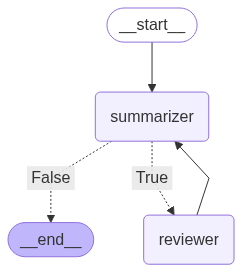

In [ ]:
from IPython.display import Image
from langchain_community.document_loaders import PyPDFLoader

#Setup the summary chatbot
summary_chatbot = SummaryAgent(model,
                               summarizer_prompt,
                               reviewer_prompt,
                               debug=True)

Image(summary_chatbot.summary_agent_graph.get_graph().draw_mermaid_png())


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pypdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.5/305.5 kB 7.0 MB/s eta 0:00:00


In [ ]:

#Input file for execution
# Load, chunk and index the contents of the pdf.
loader=PyPDFLoader("/content/drive/MyDrive/LinkedIn Learning/LangChain/Data/EcoSprint_Specification_Document.pdf")
docs = loader.load()

#Pick the first page of the doc as content
source_content=docs[0].page_content.replace("\n"," ") #first page alone
print(f"Input :==============\n {source_content}\n")

Input :==============
 EcoSprint SpecificationDocument 1.Overview● TheEcoSprint isarevolutionaryelectricvehicle(EV)designedforefficiencyandperformance. Withitssleekdesignandstate-of-the-art technology, theEcoSprintappealstoenvironmentallyconsciousdriverswhodon't want tocompromiseonstyleordrivingexperience. Ideal forcitydrivinganddailycommutes, theEcoSprint offersaperfect blendof comfort, sustainability, andinnovation. 2.DesignSpecifications● ExteriorDesign: TheEcoSprint boastsamodernandaerodynamicsilhouette, featuringsmoothlinesandacompact formfactor. AvailableincolorslikeMidnight Black, OceanBlue, andPearl White, it'sahead-turnerontheroad.● InteriorDesign: Inside, theEcoSprint isarealmof comfort andluxury. It offersaspaciouscabinwithseatingforfive, premiumupholstery, andcustomizableambientlighting. 3.PerformanceSpecifications● EngineandMotor: Poweredbyahigh-efficiencyelectricmotor, theEcoSprint delivers200horsepowerand300Nmof torque, providingasmoothandresponsivedrivingexperience.● Ba

## 05.05. Execute the summary-with-review chatbot

In [ ]:
import uuid
#Execute a single request with debug ON
config = {"configurable": {"thread_id": str(uuid.uuid4())}}

messages=[HumanMessage(content=source_content)]
result=summary_chatbot.summary_agent_graph.invoke({"messages":messages},config)

 Generator returned output : The EcoSprint is a stylish, efficient EV ideal for city driving, offering a 250-mile range from a 50kWh battery, a 7.3-second 0-to-60mph acceleration, and advanced tech features like a smart infotainment system, driver assistance, and smartphone connectivity. Its sleek design prioritizes comfort, performance, and environmental sustainability.
Iteration number : 1.0
*************
 Reviewer returned output : The summary accurately reflects the document's overview, design, performance specifications, and technological features. However, it could include more details about safety and security features, such as airbags, reinforced frame, and intrusion alarms, for a comprehensive representation. Expand slightly to include additional highlights on these aspects.
 Generator returned output : The EcoSprint is a sleek, efficient EV tailored for city driving, combining style, performance, and sustainability with a 250-mile range, advanced tech, and modern safety featu

In [ ]:
#Take user feedback on the summary through a chatbot
summary_chatbot = SummaryAgent(model,
                               summarizer_prompt,
                               reviewer_prompt,
                               debug=True)


user_inputs = [
    source_content,
    "Can you rewrite the review by focusing more on the specifications?",
    "Can you remove details about the touchscreen?"
]

#Create a new thread
config = {"configurable": {"thread_id": "thread-summarizer"}}

#Given the number of iterations, this will take a long time.
for input in user_inputs:
    print(f"----------------------------------------\nUSER : {input}")
    #Format the user message
    user_message = {"messages":[HumanMessage(input)]}
    #Get response from the agent
    ai_response = summary_chatbot.summary_agent_graph.invoke(user_message,config=config)
    #Print the response
    print(f"\nAGENT : {ai_response['messages'][-1].content}")

----------------------------------------
USER : EcoSprint SpecificationDocument 1.Overview● TheEcoSprint isarevolutionaryelectricvehicle(EV)designedforefficiencyandperformance. Withitssleekdesignandstate-of-the-art technology, theEcoSprintappealstoenvironmentallyconsciousdriverswhodon't want tocompromiseonstyleordrivingexperience. Ideal forcitydrivinganddailycommutes, theEcoSprint offersaperfect blendof comfort, sustainability, andinnovation. 2.DesignSpecifications● ExteriorDesign: TheEcoSprint boastsamodernandaerodynamicsilhouette, featuringsmoothlinesandacompact formfactor. AvailableincolorslikeMidnight Black, OceanBlue, andPearl White, it'sahead-turnerontheroad.● InteriorDesign: Inside, theEcoSprint isarealmof comfort andluxury. It offersaspaciouscabinwithseatingforfive, premiumupholstery, andcustomizableambientlighting. 3.PerformanceSpecifications● EngineandMotor: Poweredbyahigh-efficiencyelectricmotor, theEcoSprint delivers200horsepowerand300Nmof torque, providingasmoothandrespons